# Genetic Distance and Rhizosphere BCC of NAM lines 

Notes: Using NAM genetic distance matrix provided by Alberto Romero  

# Init

In [1]:
%load_ext rpy2.ipython

In [23]:
%%R


library(tidyr)
library(gridExtra)
library(reshape2)
library(phyloseq)
library(doParallel)
library(ggplot2)
library(plyr)
library(dplyr)


In [24]:
%%R
# Initialize corMLPE 
source('/home/bryan/corMLPE/corMLPE.R')

## Set file locations

In [25]:
%%R
workDir = '/home/bryan/RhizCG/PhyDist/'
treeFile = '/home/bryan/RhizCG/PhyDist/20160209_phylogeny.tre'
NAMFile = '/home/bryan/RhizCG/PhyDist/NAM_founders_distanceMatrix_v2.txt'

### Read  tables table 

In [26]:
%%R 

NAMdist = read.table(NAMFile, header = TRUE)
#reorder so that NAMdist is in same order as log2fold change matrix
NAMdist = NAMdist[c(1:6, 8, 7, 9, 10), c(1:6, 8, 7, 9, 10)]

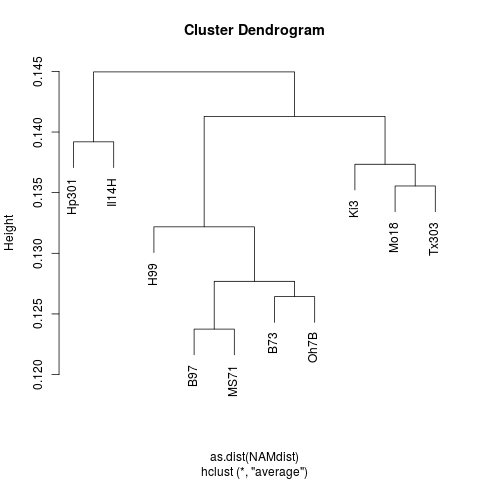

In [27]:
%%R
NAM_hc = hclust(as.dist(NAMdist), "average")
plot(NAM_hc)

In [28]:
%%R
#Read rarified phyloseq object
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3_r')
physeq.Full = readRDS(F)

physeq.NAM = subset_samples(physeq.Full, Treatment == "Nneg" & Type == "Maize" & Plant != "75-062")

m.phy = merge_samples(physeq.NAM, "Plant") %>%

    transform_sample_counts(function(x) x/sum(x))

m.phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 10 samples ]
sample_data() Sample Data:       [ 10 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


## Calculate w-Unifrac distances

In [45]:
%%R
registerDoParallel(cores=28)
phy.wunif.dist = distance(m.phy, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


# Data wrangling 

## Create melted dataframes for plot by plot comparisons

In [46]:
%%R
gd.m = melt(as.matrix(NAMdist))

#set column names and create comparison column
colnames(gd.m) = c("PlantA", "PlantB", "gene_Dist")
gd.m$PlantComp = paste(gd.m$PlantA, gd.m$PlantB, sep = "-")
gd.m %>% head


  PlantA PlantB gene_Dist PlantComp
1    B73    B73 0.0000000   B73-B73
2    B97    B73 0.1285456   B97-B73
3    H99    B73 0.1306701   H99-B73
4  Hp301    B73 0.1357241 Hp301-B73
5  Il14H    B73 0.1412994 Il14H-B73
6    Ki3    B73 0.1413460   Ki3-B73


In [47]:
%%R
ud = as.matrix(phy.wunif.dist) 
# remove lower triangle to remove duplicate values
ud[ lower.tri( ud, diag = TRUE ) ]  <- NA
head(ud)
ud.m = melt(ud, na.rm= TRUE)
colnames(ud.m) = c("PlantA", "PlantB", "w_Unif_Dist")
head(ud.m) %>% print
dim(ud.m) %>% print

   PlantA PlantB w_Unif_Dist
11    B73    B97  0.10945047
21    B73    H99  0.17109505
22    B97    H99  0.14177989
31    B73  Hp301  0.13138000
32    B97  Hp301  0.09621417
33    H99  Hp301  0.13228516
[1] 45  3


## Create functional distance variables

In [48]:
%%R
#add growing degree days
DAP = c(36, 53, 57, 61, 72, 79, 84, 88)

Plant = c("ERATE", "HELAN", "B73", "FAGES", "AMAPO", "SORSUD", "SORBI", 
          "ELCOR", "ECHCG", "ABUTH", "SETFA", "GLYMA", "MS71", "Mo18", "Il14H", "Tx303", "Oh7B",
         "B97", "Hp301", "75-062", "Ki3", "H99")
SeedSize_mg = c(.0035, 90, 333, 38, .49, 10.7, 32.39,
               3.2, 1.58, 9.6, 1.8, 174, 264, 224, 219, 279, 207,
               240, 87, 222, 228, 231)
SS = cbind(Plant, SeedSize_mg) %>% as.data.frame
head(SS) %>% print
SS$SeedSize_mg = SS$SeedSize_mg %>% as.character %>% as.numeric
(SS)

   Plant SeedSize_mg
1  ERATE      0.0035
2  HELAN          90
3    B73         333
4  FAGES          38
5  AMAPO        0.49
6 SORSUD        10.7
    Plant SeedSize_mg
1   ERATE      0.0035
2   HELAN     90.0000
3     B73    333.0000
4   FAGES     38.0000
5   AMAPO      0.4900
6  SORSUD     10.7000
7   SORBI     32.3900
8   ELCOR      3.2000
9   ECHCG      1.5800
10  ABUTH      9.6000
11  SETFA      1.8000
12  GLYMA    174.0000
13   MS71    264.0000
14   Mo18    224.0000
15  Il14H    219.0000
16  Tx303    279.0000
17   Oh7B    207.0000
18    B97    240.0000
19  Hp301     87.0000
20 75-062    222.0000
21    Ki3    228.0000
22    H99    231.0000


## Join distance tables

In [49]:
%%R
ud.m %>% head

   PlantA PlantB w_Unif_Dist
11    B73    B97  0.10945047
21    B73    H99  0.17109505
22    B97    H99  0.14177989
31    B73  Hp301  0.13138000
32    B97  Hp301  0.09621417
33    H99  Hp301  0.13228516


## Join with plant phylogenetic distance and functional distance

In [50]:
%%R
gd.m %>% head %>% print
ud.m %>% head %>% print
ud.m %>% dim %>% print


  PlantA PlantB gene_Dist PlantComp
1    B73    B73 0.0000000   B73-B73
2    B97    B73 0.1285456   B97-B73
3    H99    B73 0.1306701   H99-B73
4  Hp301    B73 0.1357241 Hp301-B73
5  Il14H    B73 0.1412994 Il14H-B73
6    Ki3    B73 0.1413460   Ki3-B73
   PlantA PlantB w_Unif_Dist
11    B73    B97  0.10945047
21    B73    H99  0.17109505
22    B97    H99  0.14177989
31    B73  Hp301  0.13138000
32    B97  Hp301  0.09621417
33    H99  Hp301  0.13228516
[1] 45  3


In [51]:
%%R
#collect sample dates
sd.m = physeq.NAM %>% sample_data %>% as("data.frame") %>%
    group_by(Plant) %>%
    summarize(Day = first(DAP)) %>%
    as.data.frame()
rownames(sd.m) = as.character(sd.m$Plant)

In [52]:
%%R
ud.m$PlantComp = paste(ud.m$PlantA, "-", ud.m$PlantB, sep = "")

Dist = left_join(ud.m, gd.m[,c(3,4)], by = "PlantComp")
tail(Dist) %>% print

Dist = left_join(Dist, sd.m, by = c("PlantA"="Plant"))
colnames(Dist)[6] = "DayA"

Dist = left_join(Dist, sd.m, by = c("PlantB"="Plant"))
colnames(Dist)[7] = "DayB"

head(Dist)

   PlantA PlantB w_Unif_Dist   PlantComp gene_Dist
40  Hp301  Tx303   0.1051067 Hp301-Tx303 0.1423267
41  Il14H  Tx303   0.1772651 Il14H-Tx303 0.1511486
42    Ki3  Tx303   0.1081990   Ki3-Tx303 0.1375954
43   Mo18  Tx303   0.1619509  Mo18-Tx303 0.1355506
44   MS71  Tx303   0.1264014  MS71-Tx303 0.1398299
45   Oh7B  Tx303   0.1300086  Oh7B-Tx303 0.1376617
  PlantA PlantB w_Unif_Dist PlantComp gene_Dist DayA DayB
1    B73    B97  0.10945047   B73-B97 0.1285456   79   79
2    B73    H99  0.17109505   B73-H99 0.1306701   79   72
3    B97    H99  0.14177989   B97-H99 0.1323307   79   72
4    B73  Hp301  0.13138000 B73-Hp301 0.1357241   79   79
5    B97  Hp301  0.09621417 B97-Hp301 0.1407961   79   79
6    H99  Hp301  0.13228516 H99-Hp301 0.1396393   72   79


In [53]:
%%R
Dist$DateCombo = ifelse(as.numeric(as.character(Dist$DayA)) < as.numeric(as.character(Dist$DayB)),
                                                                    paste(Dist$DayA, Dist$DayB, sep = "-"), 
                                                                   paste(Dist$DayB, Dist$DayA, sep = "-"))
Dist$DateCombo %>% unique

[1] "79-79" "72-79" "72-72" "79-88" "72-88" "88-88"


# Build corMLPE models

## corMLPE model with all points

In [87]:
%%R
fitNull = gls(w_Unif_Dist ~ 1, correlation = corMLPE(form= ~ PlantA + PlantB), data = Dist, method = "ML")

In [55]:
%%R
fit1 = gls(w_Unif_Dist ~ DateCombo, correlation = corMLPE(form= ~ PlantA + PlantB), 
              data = Dist, method = "ML")

In [56]:
%%R
fit2 = gls(w_Unif_Dist ~ DateCombo + gene_Dist, correlation = corMLPE(form= ~ PlantA + PlantB), data = Dist, method = "ML")

In [86]:
%%R
fit3 = gls(w_Unif_Dist ~ gene_Dist, correlation = corMLPE(form= ~ PlantA + PlantB), data = Dist, method = "ML")

In [91]:
%%R
summary(fit3)

Generalized least squares fit by maximum likelihood
  Model: w_Unif_Dist ~ gene_Dist 
  Data: Dist 
        AIC       BIC   logLik
  -184.2446 -177.0179 96.12228

Correlation Structure: corMLPE
 Formula: ~PlantA + PlantB 
 Parameter estimate(s):
      Rho 
0.4128511 

Coefficients:
                 Value Std.Error   t-value p-value
(Intercept) 0.13622855 0.1049485 1.2980509  0.2012
gene_Dist   0.06311244 0.7378499 0.0855356  0.9322

 Correlation: 
          (Intr)
gene_Dist -0.981

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.2137431 -0.6414254 -0.3063329  0.3527570  2.6352106 

Residual standard error: 0.04866634 
Degrees of freedom: 45 total; 43 residual


In [57]:
%%R
anova(fit2)

Denom. DF: 38 
            numDF   F-value p-value
(Intercept)     1 104.03401  <.0001
DateCombo       5   2.08128  0.0891
gene_Dist       1   1.68501  0.2021


In [83]:
%%R
fit2R = MuMIn::r.squaredLR(fit2, null = fit1)
paste("PhyDist^2, controlling for date R2:", fit2R) %>% print

[1] "PhyDist^2, controlling for date R2: 0.0329518500113785"


In [90]:
%%R
anova(fitNull,fit3)

        Model df       AIC       BIC   logLik   Test     L.Ratio p-value
fitNull     1  3 -186.2375 -180.8175 96.11874                           
fit3        2  4 -184.2446 -177.0179 96.12228 1 vs 2 0.007076264   0.933


In [88]:
%%R
fit3R = MuMIn::r.squaredLR(fit3, null = fitNull)
paste("PhyDist^2, not controlling for date R2:", fit3R) %>% print

[1] "PhyDist^2, not controlling for date R2: 0.000157237954897638"


In [89]:
%%R
anova(fitNull, fit1, fit2)

        Model df       AIC       BIC    logLik   Test  L.Ratio p-value
fitNull     1  3 -186.2375 -180.8175  96.11874                        
fit1        2  8 -184.4186 -169.9653 100.20930 1 vs 2 8.181116  0.1465
fit2        3  9 -183.9264 -167.6665 100.96321 2 vs 3 1.507815  0.2195
fit3        4  4 -184.2446 -177.0179  96.12228 3 vs 4 9.681854  0.0848


In [61]:
%%R
theme_pub = function (base_size = 11, base_family = "Helvetica") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
    }

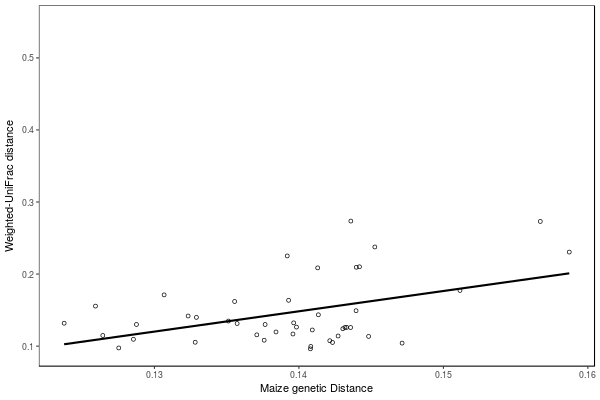

In [80]:
%%R -w 600 -h 400
#test <- function(x) {.18*x + 0.18}


                
p = ggplot(Dist, aes(y = w_Unif_Dist, x = gene_Dist)) 
p = p + geom_point(pch = 21)  #aes(size = phy_Dist), shape = 1)
#p = p + stat_smooth(method = "lm", formula = y~.29x -.236x^2 + .204, se = FALSE)
p = p + theme_pub()
p = p + ylim(c(.095,.55))
#p = p + xlim(c(0,.16))
#p = p + ggtitle("Maize genetic distance vs \n microbial community dissimilarity ")
p = p + stat_smooth(method = lm, se = FALSE, color = "black")
#p = p + stat_function(fun = test, xlim = c(.12, .16))
p = p + ylab("Weighted-UniFrac distance")
p = p + xlab("Maize genetic Distance") 
#p = p + facet_wrap(~DateCombo)
p

In [82]:
%%R
svg(filename = '/home/bryan/RhizCG/figures/MaizeGenetic_dist.svg', width = 3.14, height = 2.5)
p %>% print
dev.off()

png 
  2 
